In [1]:
#set random seeds
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(1)

import pandas as pd
import numpy as np

#machine learning
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers 
from tensorflow import keras
from sklearn.model_selection import train_test_split

#accessing files
from google.cloud import storage
import os

#display charts/images
import matplotlib.pyplot as plt

#don't need
from tensorflow.python.keras.preprocessing import sequence
# from tensorflow.python.keras.preprocessing import text
import tensorflow_hub as hub

import json




2.3.0


In [2]:
params = {
    'image_size': [299, 299],
    'text_input': (58,),
    'batch_size': 512,
    'vocab_size': 30000,
    'examples_per_file': 850, #will not change
    'test_examples_per_file': 500,
    'version': 10, #model version number
    #get this from the model zoo:
    #https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md
    'object_detection_url': 'http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2017_11_17.tar.gz',
    'object_det_thres' : 0.4,
    'object_det_len': 15,
    'caption_text_input_length': 49,
    'caption_model_version': 2,
    'meme_text_length': 58,
    'caption_embedding_dim': 300,
    'caption_vocab_size' : 10000,
    'tokenizer_start_index': 58, #index of tokenizer to signal sequence start
    'tokenizer_end_index': 57,

}




In [3]:
try:
    from google.colab import auth
    auth.authenticate_user()
    credentials=None

except ModuleNotFoundError:


    from google.oauth2 import service_account

    credentials = service_account.Credentials.from_service_account_file( #file location of GCS private key
        '/Users/jeremiahherberg/Downloads/hateful-memes-af65c70c1b79.json')

client = storage.Client(project='hateful-memes', credentials=credentials)

In [4]:
num_examples_per_tfrecordfile = params['examples_per_file'] # 850 #this will not change

In [5]:
bucket = 'jh_hateful_memes'
client = storage.Client(project='hateful-memes', credentials=credentials)
objects = client.list_blobs(bucket, prefix='hatefulmemes_')
tfrecords = []
for object_ in objects:
    path = str(object_).split(', ')[1]
    gs_path = os.path.join('gs://', bucket, path)
    tfrecords.append(gs_path) #gs_path

In [6]:
# tfrecords

In [7]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.81.89.242:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.81.89.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.81.89.242:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [8]:
def decode_example_train(example):
    '''
    decodes single tfexample from TFrecord file
    '''
    features = {'label': tf.io.FixedLenFeature([], tf.int64),
                'text': tf.io.FixedLenFeature([], tf.string),
                'text_lemma': tf.io.FixedLenFeature([], tf.string),
                'text_lemma_no_stopwords': tf.io.FixedLenFeature([], tf.string),
                'text_no_stopwords':tf.io.FixedLenFeature([], tf.string),
                'image': tf.io.FixedLenFeature([], tf.string)}
    single_example = tf.io.parse_single_example(example, features)
    
    text = tf.io.parse_tensor(single_example['text'], out_type=tf.int32)
    textL = tf.io.parse_tensor(single_example['text_lemma'], out_type=tf.int32)
    # text = tf.cast(text, tf.float32) 
    image = tf.io.decode_jpeg(single_example['image'], 3)
    image = tf.image.resize_with_pad(image, *params['image_size'])
    image = image / 127.5
    image = image -1
    label = single_example['label']
    # label = tf.cast(label, tf.float32)
    return text, image, label

def decode_example_test(example):
    '''
    decodes single tfexample from TFrecord file
    '''
    features = {'id': tf.io.FixedLenFeature([], tf.int64),
                'text': tf.io.FixedLenFeature([], tf.string),
                'text_lemma': tf.io.FixedLenFeature([], tf.string),
                'text_lemma_no_stopwords': tf.io.FixedLenFeature([], tf.string),
                'text_no_stopwords':tf.io.FixedLenFeature([], tf.string),
                'image': tf.io.FixedLenFeature([], tf.string)}
    single_example = tf.io.parse_single_example(example, features)
    
    text = tf.io.parse_tensor(single_example['text'], out_type=tf.int32)
    textL = tf.io.parse_tensor(single_example['text_lemma'], out_type=tf.int32)
    # text = tf.cast(text, tf.float32) 
    image = tf.io.decode_jpeg(single_example['image'], 3)
    image = tf.image.resize_with_pad(image, *params['image_size'])
    image = image / 127.5
    image = image -1
    label = single_example['id']
    # label = tf.cast(label, tf.float32)
    return text, image, label

def flip_image(text, image, label): 
    '''
    randombly flips image input
    
    args:
        text: text output in ds
        image: image output in ds
        label: label output in ds (can also be id)
    returns:
        text, image, label
        args will be otherwise unchanged
    '''
    
    image = tf.image.random_flip_left_right(image)

    return text, image, label


def convert_xy(text, image, label): #needs to be called last
    '''
    transforms ds output from text, image, label -> (text, image), label
    
    args:
        text: text output in ds
        image: image output in ds
        label: label output in ds (can also be id)
    returns:
        (text, image), label
        args will be otherwise unchanged
    '''
    return (text, image), label
    
    

In [9]:
def create_ds(files, params, train=True, test_examples=1000):
    '''
    function to create dataset for training/validation
    
    args:
        files: list of str, filepaths of TFrecord files to be used in DS
        params: dict with the following keys:
            batch_size: int, batch size of training/validation step
            examples_per_file: int, number of examples in each TFrecord file
        train, bool, default True, indicator if the DS is for training
        test_examples, int: default 1000 number of examples in test dataset
    returns:
        ds: tensorflow input pipeline with images, text and labels
            output of ds is: (text, image), label
        ds_batches: int, number of steps in each epoch based on the batch_size
    '''
    file_size = params['examples_per_file'] 
    batch_size = file_size * len(files)

    ds = tf.data.TFRecordDataset(filenames = files)
    if train:
        ds = ds.map(decode_example_train, 
                    num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.map(flip_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    else:
        ds = ds.map(decode_example_test)
    ds = ds.map(convert_xy, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if train:
        ds = ds.batch(batch_size, drop_remainder=True)
    else:
        ds = ds.batch(test_examples)
    ds = ds.cache() 
    
    ds_batches = 10 #(len(files) * file_size) // batch_size
    return ds, ds_batches
    
    

In [10]:
def download_file(client, bucket, file_name):
    '''
    downloads a file from a GCS bucket into working directory

    args:
        client: google.cloud.storage.Client object
        bucket: str, name of bucket to download file from
        file_name: str, file name to download
    returns: None
    
    '''
    _bucket = client.bucket(bucket)
    blob = _bucket.blob(file_name)
    blob.download_to_filename(file_name)

In [11]:
def get_object_detection_model(params):
    '''
    downloads pretained object detection model from tf zoo 
    and creates model instance
    
    args:
        params: dict with the following keys:
            object_detection_url: str, url of model in model zoo:
    (https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md)
    
    returns:
        pretrained object detection model
    '''
    url = params['object_detection_url']
    model_name = url.split('.tar.')[0].split('/')[-1]
    local_model_location = tf.keras.utils.get_file(fname=model_name,
                                                  origin=url,
                                                  untar=True)
    model_path = os.path.join(local_model_location, 'saved_model')
    model = hub.load(model_path)
    model = model.signatures['serving_default']
    return model

def decode_single_object_detection(predictions, idx, threshold, max_objects):
    '''
    decodes a single prediction of all object classes in the prediction
    
    args:
        predictions: dictionary, prediction dictionary
            must have following keys:
            detection_classes: tensor of detection classes
            detection_scores: tensor of confidence of each detected object
        idx: int, the index of the predictions dictionary that is being decoded
        threshold: float, between 0 - 1, minimum confidence of detected objects
            to be included in list of objects detected
        max_objects: int, maximum number of objects to be included in prediction
            if there are less predicted objects above threshold, returned list will
            be zero padded
            
    returns:
        array of classes of objects being predicted
    '''
    classes = predictions['detection_classes'][idx]
    confidences = predictions['detection_scores'][idx]
    predicted_classes = []
    for indx in range(len(confidences)):
        if confidences[indx] < threshold:
            break
        predicted_classes.append(int(classes[indx].numpy()))
    return sequence.pad_sequences([predicted_classes], maxlen=max_objects)[0].tolist()



def make_object_detectionDS(params, images, model):
    '''
    converts a batch of images to a batch of predicted classes of objects
    
    args:
        params: dictionary with following keys:
            object_det_thres: float, minimum confidence of detected objects
            to be included in list of objects detected, must be between 0 - 1
            object_det_len: int, maximum number of objects to be included in 
            prediction if there are less predicted objects above threshold, 
            returned tensor will be zero padded
        images tensor, batch of images to get predicted classes of objects
            for
        model: pre-trained object detection model
    
    returns: tensor shapped [bs, params['object_det_len']], output of model
        of predicted classes each image contains, zero-padded so that each
        image prediction has a len of params['object_det_len'], and predictions
        under params['object_det_thres'] are filtered out
    '''
    thres = params['object_det_thres']
    maxlen = params['object_det_len']
    model_output = model(images)
    predictions = []
    for idx in range(len(images)):
        single_image_output = decode_single_object_detection(model_output, idx,
                                                            thres, maxlen)
        predictions.append(single_image_output)
    predictions = tf.convert_to_tensor(predictions)
    return predictions

def transform_normalized_uint8(data):
    '''
    transforms a tensor normalized (0 - 1) to dtype uint8
    
    args:
        data: tensor, data to be transformed
        
    returns:
        tensor of data in dtype of unit8 and no longer normalized
    '''
    data *= 255
    data = tf.cast(data, tf.uint8)
    return data
    

In [12]:
def pair_separableConv1D(x, 
                         filters, kernal_size, act, first_reg, sec_reg,
                        maxpooling_poolsize):
    '''
    function to add the following layers to a Keras Functional model:
        layers.SeparableConv1D
        layers.SeparableConv1D
        layers.MaxPooling1D
    
    args:
        x: keras input layer, or series of layers that can be traced to input layer
        kernal_size: int, kernal size for SeparableConv1D layers
        act: str, activation for SeparableConv1D layers
        first_reg, keras regularizer to pass into 1st conv layer
        sec_reg, keras regularizer to pass into 2nd conv layer
        maxpooling_poolsize: int, poolsize for maxpooling layer
    
    returns:
        x: x that was input into fn with above layers added
    '''
    x = layers.SeparableConv1D(filters=filters, kernel_size=kernal_size, 
                              activation=act, padding='same',
                              kernel_regularizer=first_reg)(x)
    x = layers.SeparableConv1D(filters=filters, kernel_size=kernal_size, 
                              activation=act, padding='same',
                              kernel_regularizer=sec_reg)(x)
    x = layers.MaxPooling1D(pool_size=maxpooling_poolsize, padding='same')(x)
    x = layers.BatchNormalization()(x)
    return x

In [13]:
def conv2dset(x, 
              conv_filter, kernel, regularizer=None, 
              maxpooling_poolsize=2, 
              conv_act=None, 
              dense_units=None, dense_act=None):
    '''
    function to add the following layers to a Keras Functional model:
        layers.Conv2D
        MaxPooling2D
        Batchnormalization
        (activation layer)
        layers.Dense (if applicable)
    
    args:
        x: keras input layer, or series of layers that can be traced to input layer
        conv_filter: int, number of filters in Conv2D layer
        kernel: int, kernel size in Conv2D layer
        regularizer: keras.regularizers object, default: None, regularizer in 
            Conv2D layer
        maxpooling_poolsize: int, default 2, poolsize for maxpooling layer
        conv_act: keras layer (without the "()"), default None, activation
            layer that will go after the batchnormalization layer
        dense_units: int, default None, number of units in dense layer
            if None, there will be no dense layer
        dense_act: str, default None, activation in dense layer
    
    returns:
        x: x that was input into fn with above layers added
        
    '''
    x = layers.Conv2D(filters=conv_filter, kernel_size=kernel, padding='same', 
                      kernel_regularizer=regularizer)(x)
    if maxpooling_poolsize:
        x = layers.MaxPooling2D(maxpooling_poolsize)(x)
    # x = layers.BatchNormalization()(x)
    if conv_act:
        x = conv_act()(x)
    if dense_units:
        x = layers.Dense(dense_units, activation=dense_act)(x)
    
    return x

def convblock(x, conv_fn, filters, regularizer, conv_act, kernal=5):
    '''
    makes a block of convolution layers
    
    todo -- work on documentation 
    '''
    count = 0
    for _ in range(2):
        for filter_ in filters:
            count +=1
            if count == 2:
                x1 = conv_fn(x, filter_, kernal, regularizer, 2, conv_act,)
                x = x1
            else:
                x = conv_fn(x, filter_, kernal, regularizer, None, conv_act)
    x = layers.Add()([x, x1])
    return x



In [14]:
def get_image_captions(params, images):
    '''
    creates captions to a group of images
    
    args:
        params: dictionary with at least the following keys:
            caption_text_input_length: int, length of captions
            tokenizer_start_index: int, value to signal start of caption
            tokenizer_end_index: int, value to signal end of caption
            
        images: tensor, dtype: tf.float32 shaped (None, 299, 299, 3) None is the 
        number of images, each image should be normalized to have
        pixel values of -1 to 1. Images to be captioned

            
    returns:
        captions: tensor, dtype float, shaped 
        (None, params['caption_text_input_length'])None is the number of 
        images, image caption sequences
    '''
    num_images = len(images)
    caption_len = params['caption_text_input_length']
    caption_end_index = params['tokenizer_end_index']



    
    captions = list()
    for image in range(num_images):
        img = images[image]
        img = tf.expand_dims(img, axis=0)
        txt_input = np.zeros((caption_len))
        result = params['tokenizer_start_index']
        for idx in range(caption_len):
            txt_input[idx] = result
            # with tf.device('/TPU:0'):
            #     result = caption_step(img, txt_input)
                # result = strategy.run(caption_step, args=(img, txt_input))
            result = get_capt(img, txt_input)
            result = result.values[0].numpy()[0]
            if result == caption_end_index:
                break
        captions.append(txt_input)
    captions = tf.convert_to_tensor(captions)
    return captions
        
@tf.function
def get_capt(img, txt):
    def caption_step(image_, text_):
        '''
        evaluate model here
        '''
        txt_ = tf.expand_dims(text_, axis=0)
        pred = caption_model((image_, txt_))


        return pred
    result = strategy.run(caption_step, args=(img, txt))
    return result
    

In [169]:
def create_model(params=params,
                dense_nodes=100,
                ltsm_units=128,
                ltsm_dense_units=64):
    '''
    creates model with two inputs and out output

        
    '''
    #set some fixed variables
    text_input_shape = params['text_input']
    vocab_size = params['vocab_size']
    image_size = params['image_size']
    object_maxlen = params['object_det_len']
    caption_input_len = params['caption_text_input_length']
    meme_text_len = params['meme_text_length']
    caption_dim = params['caption_embedding_dim']
    caption_vocab_size = params['caption_vocab_size']
    
    num_object_classes = 81

    relu = layers.ReLU
    leaky = layers.LeakyReLU
    reg = keras.regularizers.l2(0.001,)
    dense_act = 'tanh'
    
    #model inputs
    input_text = layers.Input(text_input_shape, name='text_input')
    embedding = layers.Embedding(input_dim=vocab_size, output_dim=64, 
                                 input_length=meme_text_len, mask_zero=True)(input_text)

    
    input_caption = layers.Input((caption_input_len,), name='caption_input')
    embedding_caption = layers.Embedding(input_dim=caption_vocab_size, output_dim=caption_dim,
                                         input_length=caption_input_len, mask_zero=True)(input_caption)
    
    #bidirectional LSTM - image captions
    x_caption_bidir = embedding_caption
    x_caption_bidir = layers.Bidirectional(layers.LSTM(ltsm_units))(x_caption_bidir)
    # x_caption_bidir = layers.Dense(ltsm_dense_units, activation = 'relu')(x_caption_bidir)
    x_caption_bidir_out = layers.Dense(dense_nodes, activation=dense_act,
                                       name='bidirectional_caption_out')(x_caption_bidir)
    x_caption_bidir_out = layers.LeakyReLU()(x_caption_bidir_out)
    

    


    #bidirectional LSTM - original text
    x_bidir = embedding
    x_bidir = layers.Bidirectional(layers.LSTM(ltsm_units))(x_bidir)
    # x_bidir = layers.Dense(ltsm_dense_units, activation = 'relu')(x_bidir)
    x_bidir_out = layers.Dense(dense_nodes, activation=dense_act, name='bidirectional_out')(x_bidir)
    x_bidir_out = layers.LeakyReLU()(x_bidir_out)

    # #1D convolution - original text
    # x_text = embedding
    # x_text = pair_separableConv1D(x_text, 128, 4, 'relu', reg, None, 4)
    # x_text = pair_separableConv1D(x_text, 128, 4, 'relu', None, None, 4)
    # x_text = layers.Flatten()(x_text)
    # # x_text = layers.Dense(dense_nodes, activation='tanh',kernel_regularizer=reg)(x_text)
    # output_layer_text = layers.Dense(dense_nodes, activation='sigmoid', name='text_output')(x_text)

    # #1D convolution - caption text
    # x_text_caption = embedding_caption
    # x_text_caption = pair_separableConv1D(x_text_caption, 128, 4, 'relu', reg, None, 4)
    # x_text_caption = pair_separableConv1D(x_text_caption, 128, 4, 'relu', None, None, 4)
    # x_text_caption = layers.Flatten()(x_text_caption)
    # # x_text_caption = layers.Dense(dense_nodes, activation='tanh',kernel_regularizer=reg)(x_text_caption)
    # x_caption_bidir_out_conv = layers.Dense(dense_nodes, activation='sigmoid', name='text_output_caption')(x_text_caption)

    
    
    text_outputs = layers.Concatenate()([x_caption_bidir_out, x_bidir_out, ]) # Concatenate
#     text_outputs = layers.Dense(dense_nodes)(text_outputs)
    

    x = text_outputs
    
    # x = layers.Reshape(( 2, dense_nodes))(x)
    # x = layers.LSTM(64)(x)
    x = layers.Dense(dense_nodes, activation=dense_act)(x)
    # x = layers.LeakyReLU()(x)
    # x = layers.Flatten()(x)
    #consider adding an intrum dense layer here
    final_output = layers.Dense(1, activation='sigmoid', name='final_out')(x)
    

    
    model = keras.Model([input_caption, input_text], final_output) #input_image
    metrics = [
          keras.metrics.TruePositives(name='tp'),
    #           keras.metrics.FalsePositives(name='fp'),
    #           keras.metrics.TrueNegatives(name='tn'),
          keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy'),
    #           keras.metrics.Precision(name='precision'),
    #           keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),
    ]
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.0003, 10 *3, 0.75)
    model.compile(
    optimizer=tf.keras.optimizers.Adam(schedule),
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.01),
    metrics=metrics)
    
    return model
    
#
def get_caption_model(params, client, bucket):
    '''
    creates pretrained image caption model
    '''
    
    txt_input_length = params['caption_text_input_length']
    model_num = params['caption_model_version']
    model_path = 'image_caption_model_v{}.h5'.format(model_num)
    if not os.path.isfile(model_path):
        download_file(client, bucket,model_path)
    
    img_inp = layers.Input((*params['image_size'], 3), name='image_input')
    inception = tf.keras.applications.InceptionV3(include_top=False, 
                                                  input_shape=(*params['image_size'], 3))
    img_x = inception(img_inp)
    img_x = layers.Reshape((64, 2048))(img_x)
    
    
    txt_inp = layers.Input((txt_input_length,), name='text_input')
    txt_x = txt_inp
    
    caption_model = tf.keras.models.load_model(model_path)
    out = caption_model((img_x, txt_x))
    out = tf.argmax(out, axis=-1, name='model_prediction')
    
    model = keras.Model([img_inp, txt_inp], out)
    for layer in model.layers:
        layer.trainable = False
    return model
    
    



In [170]:
train_files, valid_files = train_test_split(tfrecords,
                              test_size=.2, random_state=1)


In [171]:
train_ds, train_steps = create_ds(train_files, params)
valid_ds, valid_steps = create_ds(valid_files, params)

In [172]:
tf.random.set_seed(1)
np.random.seed(1)
with strategy.scope():
    model = create_model()
    model.summary()
    # caption_model = get_caption_model(params, client, 'jh_hateful_memes')

Model: "functional_48"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
caption_input (InputLayer)      [(None, 49)]         0                                            
__________________________________________________________________________________________________
text_input (InputLayer)         [(None, 58)]         0                                            
__________________________________________________________________________________________________
embedding_47 (Embedding)        (None, 49, 300)      3000000     caption_input[0][0]              
__________________________________________________________________________________________________
embedding_46 (Embedding)        (None, 58, 64)       1920000     text_input[0][0]                 
______________________________________________________________________________________

In [173]:
# for train_data, train_groundTruth in train_ds:
#     for valid_data, valid_groundTruth in valid_ds:
#         train_text, train_images = train_data
#         train_groundtruth = train_groundTruth
#         train_captions = get_image_captions(params, train_images)
#         train_DATA = (train_captions, train_text)
        
        
#         valid_text, valid_images  = valid_data
#         valid_groundtruth = valid_groundTruth
#         valid_captions = get_image_captions(params, valid_images)
#         valid_DATA = (valid_captions, valid_text)
        
#         break

 

In [174]:
#calculate class weights
target_0 = 5450 #these values will not change (are from review of test ds)
target_1 = 3050
total = target_0 + target_1

class_weight_0 = (1 / target_0) * (total) / 2.0
class_weight_1 = (1 / target_1) * (total) / 2.0

class_weights = {0: class_weight_0, 1: class_weight_1}


#early stopping if validation auc stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', #val_auc
                                patience=25,
                                mode='max',
                                restore_best_weights=True)

# (text, image), label
history = model.fit(train_DATA, 
                    train_groundtruth, 
                    steps_per_epoch=25, 
                    validation_data=(valid_DATA, valid_groundtruth), 
                    validation_steps=5,
                    callbacks=[early_stopping],
                    class_weight=class_weights,
                    epochs=250)

Epoch 1/250
 1/25 [>.............................] - ETA: 0s - loss: 0.6984 - tp: 33.0000 - fn: 68.0000 - accuracy: 0.5809 - auc: 0.5078WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0029s vs `on_train_batch_end` time: 0.0402s). Check your callbacks.


25/25 [==============================] - ETA: 0s - loss: 0.6954 - tp: 1196.0000 - fn: 1276.0000 - accuracy: 0.5065 - auc: 0.5019WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0020s vs `on_test_batch_end` time: 0.0253s). Check your callbacks.


25/25 [==============================] - 9s 348ms/step - loss: 0.6954 - tp: 1196.0000 - fn: 1276.0000 - accuracy: 0.5065 - auc: 0.5019 - val_loss: 0.7072 - val_tp: 578.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.3400 - val_auc: 0.5608
Epoch 2/250
25/25 [==============================] - 2s 71ms/step - loss: 0.6902 - tp: 2320.0000 - fn: 152.0000 - accuracy: 0.4278 - auc: 0.6439 - val_loss: 0.6938 - val_tp: 443.0000 - val_fn: 135.0000 - val_accuracy: 0.4924 - val_auc: 0.6109
Epoch 3/250
25/25 [==============================] - 2s 68ms/step - loss: 0.6585 - tp: 1725.0000 - fn: 747.0000 - accuracy: 0.6350 - auc: 0.7048 - val_loss: 0.6466 - val_tp: 244.0000 - val_fn: 334.0000 - val_accuracy: 0.6465 - val_auc: 0.6309
Epoch 4/250
25/25 [==============================] - 2s 69ms/step - loss: 0.5771 - tp: 1594.0000 - fn: 878.0000 - accuracy: 0.7351 - auc: 0.7946 - val_loss: 0.6911 - val_tp: 332.0000 - val_fn: 246.0000 - val_accuracy: 0.5982 - val_auc: 0.6419
Epoch 5/250
25/25 [=================

In [175]:
def plot_metric(metric1, metric2, ylabel):
    plt.plot(history.history[metric1], label=metric1)
    plt.plot(history.history[metric2], label=metric2)
    plt.ylabel(ylabel)
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

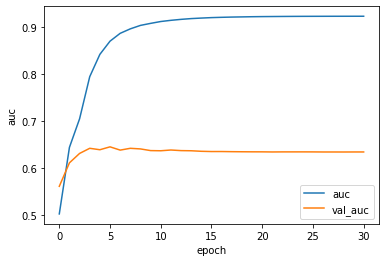

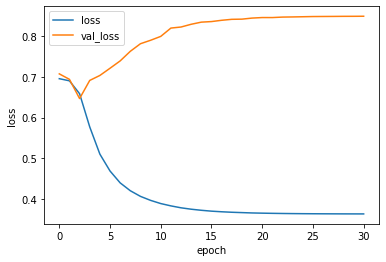

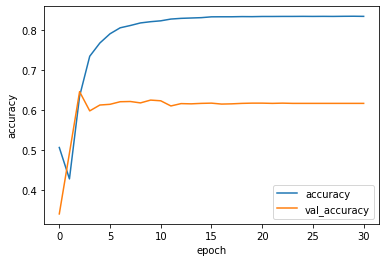

In [176]:
plot_metric('auc', 'val_auc', 'auc')
plot_metric('loss', 'val_loss', 'loss')
plot_metric('accuracy', 'val_accuracy', 'accuracy')

In [177]:
max(history.history['val_auc']) #relu - 0.664/0.653/0.635 // tanh + leaky -- 0.651/0.661/0.649 // leaky -- 0.6506/0.656/0.648
#tanh - 0.658 / .649 / 0.651
#conv - relu -  0.652 // tanh - 0.638

0.6449816226959229

In [178]:
params['version'] = 10
model_name = 'model_hateful_memes_v{}.h5'.format(params['version'])
model.save(model_name)
bucket = client.bucket('jh_hateful_memes')
blob = bucket.blob(model_name)
blob.upload_from_filename(model_name)#fix this

In [179]:
#make into a fn
bucket = 'jh_hateful_memes_test'
client = storage.Client(project='hateful-memes', credentials=credentials)
objects = client.list_blobs(bucket, prefix='hatefulmemes_')
tfrecords = []
for object_ in objects:
    path = str(object_).split(', ')[1]
    gs_path = os.path.join('gs://', bucket, path)
    tfrecords.append(gs_path) #gs_path

In [180]:
test_ds, test_steps = create_ds(tfrecords, params, train=False)

In [181]:
for x_test, ids in test_ds:

    test_text, test_images = x_test
    test_captions = get_image_captions(params, test_images)
    test_DATA = (test_captions, test_text)




    predictions = model.predict(test_DATA, steps=10)
    prediction_ids = ids



In [182]:
prediction_dict = {
    'id': prediction_ids,
    'proba': np.concatenate(predictions),
    'label': np.ones(1000, int)
}
submission_ds = pd.DataFrame(prediction_dict)



In [183]:
submission_ds.to_csv('submission.csv', index=False)